In [21]:
import pandas as pd
import numpy as np
import os.path
import matplotlib.pyplot as plt 
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.linear_model import Ridge

In [2]:
path_u = os.path.abspath("usersData.csv")
path_f = os.path.abspath("followers_views.csv")
path_l = os.path.abspath("likes_views.csv")
user = pd.read_csv(path_u)
follower = pd.read_csv(path_f)
likes = pd.read_csv(path_l)
del path_u, path_f, path_l

In [3]:
user["likes*followers"] = np.sqrt(user['avg_likes']*user["avg_followers"])
user["followers/post"] = user["avg_followers"] / user["avg_posts"]
user["comments/likes"] = user["avg_comments"] / user["avg_likes"]
user["focus dif"] = user["max_likes"] - user["min_likes"]
user["focus ratio"] = user["max_likes"] / user["min_likes"]
user.head()

,avg_likes,avg_comments,avg_followers,avg_posts,max_likes,min_likes,avg_views,likes*followers,followers/post,comments/likes,focus dif,focus ratio
0,97.50,3.00,13178.0,1967.0,113,59,333.1667,1133.514446,6.699542,0.030769,54,1.915254
1,91.75,9.25,4228.0,1402.0,174,39,308.6250,622.831438,3.015692,0.100817,135,4.461538
2,33.00,3.50,2212.0,2471.0,46,23,126.7500,270.177719,0.895184,0.106061,23,2.000000
3,20.00,3.50,203.0,1838.0,26,16,65.5000,63.718129,0.110446,0.175000,10,1.625000
4,13.20,1.20,132.0,309.0,18,9,61.2000,41.742065,0.427184,0.090909,9,2.000000


In [4]:
follower.head()

,followers,views
0,13178,250
1,13178,604
2,13178,239
3,13178,858
4,13178,271


In [5]:
likes.head()

,likes,views
0,98,250
1,100,604
2,109,239
3,103,858
4,106,271


#### Create graphs 

Mean views: 745.0688204134648


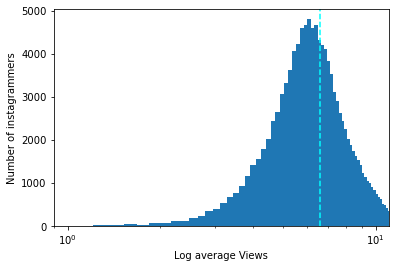

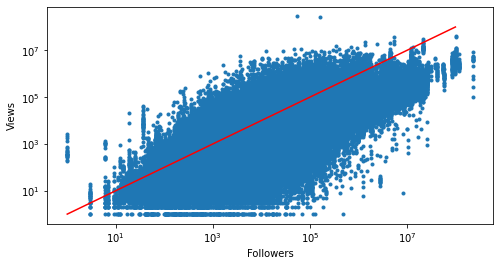

Text(0, 0.5, 'Views')

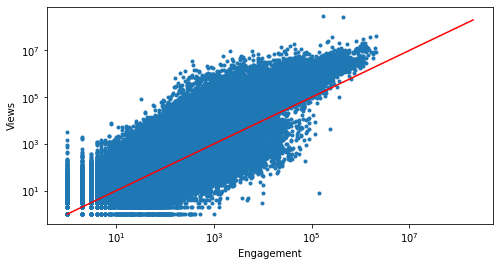

In [6]:
views_log = np.log(user["avg_views"])
print("Mean views: {}".format(np.exp(views_log.mean())))
plt.hist(views_log,bins=100)
plt.axvline(x=views_log.mean(),linestyle='--',color='cyan')
plt.xscale("log")
plt.xlim(left=0.9,right=11)
plt.xlabel("Log average Views")
plt.ylabel("Number of instagrammers")
plt.show()

plt.figure(figsize=(8,4))
plt.plot(follower["followers"],follower["views"],".")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Followers")
plt.ylabel("Views")
plt.plot([1,10**8],[1,10**8],"r-")
plt.show()

plt.figure(figsize=(8,4))
plt.plot(likes["likes"],likes["views"],".")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Engagement")
plt.plot([1,2*10**8],[1,2*10**8],"r-")
plt.ylabel("Views")

#https://stackoverflow.com/questions/46415327/matplotlib-plot-points-look-fuzzy-in-python-sharp-in-ipython

#### Merging will be hard, followers are not unique 

In [7]:
follower[follower['followers']== 13178].head(11)

,followers,views
0,13178,250
1,13178,604
2,13178,239
3,13178,858
4,13178,271
5,13178,317
6,13178,318
7,13178,126
136754,13178,1629
136755,13178,1866


#### Transform "likes" and "followers" using log scale , drop inf 

In [18]:
user_scaled = user.copy()
user_scaled.loc(1)["avg_likes"] = user["avg_likes"] / np.log(user["avg_likes"])
user_scaled.loc(1)["avg_followers"] = user["avg_followers"] / np.log(user["avg_followers"])
user_scaled = user_scaled.loc[user_scaled["avg_likes"] != np.inf,:]

#### Using "avg_views" as the variable to predict

Random Forest unscaled

In [9]:
x_full, y_full = user.drop("avg_views",1), user["avg_views"]
forest = RandomForestRegressor()
scores = cross_val_score(forest, x_full, y_full, scoring='r2', cv=5)
print("CV R2 score: {}".format(scores.mean()))
scores


CV R2 score: 0.5782933842095097


array([0.60786177, 0.18599855, 0.74275372, 0.6778745 , 0.67697838])

Random Forest scaled 

In [19]:
x_full, y_full = user_scaled.drop("avg_views",1), user_scaled["avg_views"]
forest = RandomForestRegressor()
scores = cross_val_score(forest, x_full, y_full, scoring='r2', cv=5)
print("CV R2 score: {}".format(scores.mean()))
scores


CV R2 score: 0.5669912013948547


array([0.60451407, 0.20303972, 0.72917551, 0.6348303 , 0.6633964 ])

Ridge scaled

In [22]:
ridge = Ridge()
scores = cross_val_score(ridge, x_full, y_full, scoring='r2', cv=5)
print("CV R2 score: {}".format(scores.mean()))
scores


CV R2 score: 0.6176009849044936


array([0.64787687, 0.50037248, 0.61071777, 0.65533374, 0.67370406])

In [25]:
#user_scaled.describe()